<h3> In this recommendation system we will be using SVD to determine relevant movies to users based soley off user ratings. The basic philosphy here is that we are able to recomend movies based off user ratings and make inferences between users, movies and ratings to make predictions as to what movies might be good recommendations for a give user based of titles that they are interested in. The method we are using is a UV-Decomposition method (Truncated SVD), meaning we will decompose a utility matrix into three seperate matricies that will contain latent variables (variables that cannot be observed but determine hidden relationships in the data that contribute to what gets recommended) and will allow us to make inferences and generate recommendations for users.</h3>
<h3>Let's load in the 100k movie dataset which you can obtain from <a href = "https://grouplens.org/datasets/movielens/100k/">here</a>. I am using the dated version which is stable for those who want to replicate this analysis.</h3>

In [1]:
import pandas as pd
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u.data', 
                      sep='\t', names=r_cols,encoding='latin-1')

In [2]:
m_cols = ['movie_id', 'movie_title' ,'release_date','video_release_date', 'imdb_url', 'unknown', 'action', 
        'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
        'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
movies = pd.read_csv('u.item', sep='|', names=m_cols,
                    encoding='latin-1')

In [3]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


<h3>Our ratings data contains the associated user/movie id's, the rating the user gave the movie and the time it was rated.</h3>

In [4]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<h3>Our movies data contains information about the movies including the whether it belongs to a certain genre or not. 1 if it is that genre, 0 if it's not. This product information is useful for content based recommendation systems, but we wont be using these features in this model.</h3>
<h3>Now let's join our user ratings to our movie data to get the movie titles.</h3>

In [5]:
movie_ratings = pd.merge(ratings, movies[['movie_id', 'movie_title']], on='movie_id')
movie_ratings.head()

,user_id,movie_id,rating,unix_timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


<h3>So now we have our user ratings and movie titles, let's flatten/transform our data into a utility matrix so that we have n x m matrix where we have n users (as our index) and m movie titles (as our features). This is process in pandas is similar to the pivot function in sql and achieves the same thing. The resultant will be our utility matix, M.</h3>

In [6]:
M = movie_ratings.pivot_table(values='rating', index='user_id', columns='movie_title', fill_value=0)
M.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,2,5,0,0,3,4,0,0,...,0,0,0,5,3,0,0,0,4,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,2,0,0,0,0,4,0,0,...,0,0,0,4,0,0,0,0,4,0


<h3>Now we need to transpose our matrix so that rows will be our movies and columns will be users. We will do this because our SVD method will be compressing our features and we want to predict movies, so they must be preserved.</h3>

In [7]:
X = M.T
print(M.shape, X.shape)

(943, 1664) (1664, 943)


<h3>Now let's import TruncatedSVD from sklearn to decompose our matrix. This means we are attempting to find a matrix U that has n rows and d columns, a matrix V with d rows and m columns and a matrix $ \Sigma$ that is a diagonal matrix that stores information about the decomposition process (referred to as singular values) and is all zeros off the diagonal and when combined approximate M. If successful then what we have here is the ability to relate users and movies, meaning that in d dimensions we can use an entry in product $U \Sigma V$ to estimate the corresponding entry in M. This means we can fill in the blanks and complete our matrix. The feature reduction step we're taking here is compressing the user ratings down to 15 components that represent a summarized view of the users tastes.</h3>
<h3>Now the Truncated SVD method is slightly different from the regular SVD method. As below, we see that our utility matrix M is approxiate by $U_k \Sigma_k V_k^T$.</h3>
<h3>$$M_k=U_k \Sigma_k V_k^T$$</h3>
<h3>Where $ \Sigma $ is a diagonal matrix that stores information about the decomposition process.</h3>
<h3>The truncate method (or reduced rank) differs by instead of choosing all features in our $U \Sigma V$ matricies it selects the top k features. Here, k is the input parameter that we specify below refered to as n_components in scikit learn. There is a trade off between how many components you choose, the lower the components the lower the accuracy of the approximation, the higher the slower working with the SVD will be.</h3>
<h3>The approximation here will be based on generalized user tastes and underlying concepts (or latent vaiables) that are hidden in our utility matrix. So, we know our utility matrix M contains users as rows and movies as columns, therefore our matrix U can be throught to possess the relationships between users and concepts. For example, a given user may only like one genre of movie, maybe they only rate those, and maybe they love the genre but don't like the partcular films this will provide numeric representations that can draw concepts. Our matrix V can be thought to relate movies to concepts, for example certain titles relating to certain genres. Lastly our matrix $ \Sigma $ can be thought to provide the strength of a given concept. Concepts are not always clearly distinguishable, for example analagous to our user/movies in our matrix M, there may be numous concepts of varying magnitudes that are not easily determined.</h3>

In [8]:
import sklearn
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=15, random_state=1)
result = SVD.fit_transform(X)
result.shape

(1664, 15)

<h3>So now we need to determine how similar the movies are based on generalized user tastes which means we're going to need to use a correlation coefficient which will be Pearsons r. Our resultant matrix should now be 1664 x 1664 and each column will contain the correlation between a movie and to the entire movie list working down the rows. We will use the numpy corrcoef to achieve this.</h3>

In [9]:
import numpy as np
cm = np.corrcoef(result)
cm.shape

(1664, 1664)

<h3>Now let's create a simple function that will take a given movie title and lower bound correlation and return a list of similar titles to it within the specified correlation range.</h3>

In [10]:
movies = M.columns
movie_list = list(movies)

def get_recommendations(title: str, lower_interval: float):
    title_index = movie_list.index(title)
    correlated_title = cm[title_index]
    #return a list of titles by indexing our columns by the titles in our cm index column that are lower_interval < x < 1
    return list(movies[(correlated_title<1.0) & (correlated_title > lower_interval)])

In [11]:
get_recommendations('Terminator, The (1984)', 0.95)

['Alien (1979)',
 'Aliens (1986)',
 'Die Hard (1988)',
 'Empire Strikes Back, The (1980)',
 'Fugitive, The (1993)',
 'Hunt for Red October, The (1990)',
 'Indiana Jones and the Last Crusade (1989)',
 'Raiders of the Lost Ark (1981)',
 'Terminator 2: Judgment Day (1991)']

In [12]:
get_recommendations('Star Trek: The Wrath of Khan (1982)', 0.95)

['Hunt for Red October, The (1990)',
 'Star Trek III: The Search for Spock (1984)',
 'Star Trek IV: The Voyage Home (1986)',
 'Star Trek VI: The Undiscovered Country (1991)']

<h3> So, to reiterrate, we are making recommendations to users based on generalized user tastes. Now, it appears our system has done a pretty decent job at recommending similar movies. For both tests, the movies returned do seem like relevent titles for the most part. In terms of performance metrics, due to the decomposition and generalization we can't calculate a RMSE as we could if this were a normal matrix factorization, where of course we could hold out a test set and get a RMSE of how many stars our model is off by.</h3>
<h3>But it's also important to note that accuracy isn't always the best metric to base recommenders off. Let's look at our star trek example, the most highly correlated films here would be the other movies in the series. If we were to recommend only those titles we would essentially be limiting the diversity of our predictions and hence limiting the content for users not offering new and exciting titles. We can imagine that if other similar movies are recommended it might encourage a user to stay engaged by trying out a different movie series for example.</h3>
<h3>What we can do though is get some variance metrics, that will basically tell us how much information has been captured in our decomposition/dimensionality reduction process and hence whether increasing the number of components might provide superior predictions by capturing more information/variance. If you are familiar with PCA or dimensionality reduction then this should be familiar to you. In fact, the two dimentionality reductions techniques are similar in that PCA matrix factorization is done on the covariance matrix (SVD is often used to find the priciple components) and truncated SVD is performed on the data matrix. As previously mentioned choosing the n_components is a trade off between speed and accuracy; the more components we keep the more information we retain (the higher the variance) but the longer it takes to process. We can estimate the variation from $\sigma = \sum_j \lambda_j$ and the variance ratio for component $j$ as $r_j = \frac{\lambda_j}{\sigma}$ and below we can see how the variance ratio drops with the decrease in number of components.</h3>

In [33]:
svd = TruncatedSVD(n_components=200, random_state=1)
result = svd.fit_transform(X)
print('SVD using 200 components: ', svd.explained_variance_ratio_.sum(),
      '\nSVD using 15 components: ',SVD.explained_variance_ratio_.sum())

SVD using 200 components:  0.825361910538 
SVD using 15 components:  0.437754401921


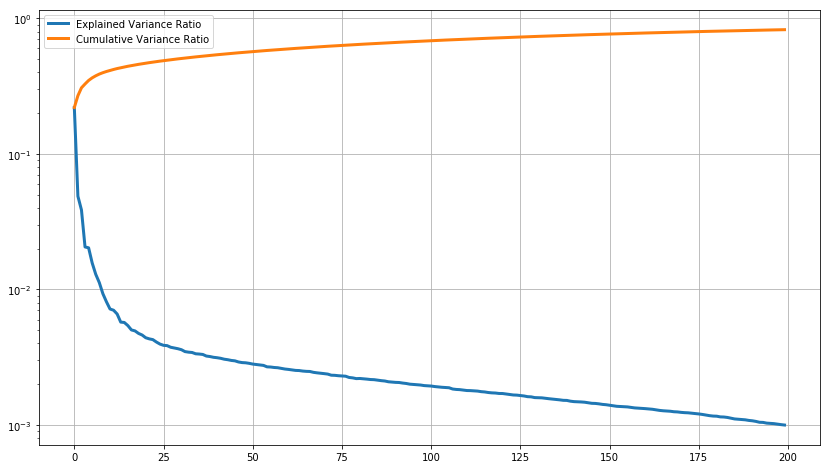

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,8))
plt.semilogy(svd.explained_variance_ratio_, linestyle='solid', lw = 3, label='Explained Variance Ratio');
plt.semilogy(svd.explained_variance_ratio_.cumsum(), linestyle='solid', lw = 3, label='Cumulative Variance Ratio');
plt.legend(('Explained Variance Ratio', 'Cumulative Variance Ratio'))
plt.grid(True)

<h3>So, how might we measure performance metrics for this recommendation system then? Well
This kind of collaborative filtering also has many advantages such as:<br />
<ul>
    <li> Efficiency - don't have to refer to high dimensional matricies, offers speed and scalability.</li>
    <li>Predictions for new users - no review data is needed for new users, just titles they have viewed.</li>
</ul><br />
If testing this in production (A/B test, multiarm bandit comparing multiple recommender methods) you could derive metrics to indicate the click through rate of the recommended titles and then the engagement/user satisfaction based on explicit measures ratings etc. or by determining implicit ratings through relevent KPI measures or measurable metrics that indicate success, in our movie example perhaps this would be watched the full movie and then search for the next in a series - indicates 5 stars for the first movie etc.</h3>